# An Overview of the CTC

In [1]:
import torch
from torch import nn

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# plt.style.use("seaborn")
sns.set()


In [127]:

def get_rand(shape=(20, 5)):
    shape = (shape[0], 1, shape[1])
    return torch.rand(*shape)


def get_flattish(shape=(20, 5)):
    shape = (shape[0], 1, shape[1])
    d = torch.rand(*shape) * 0.01
    return d
    

def get_bump(shape=(20, 5), big_activ = (1,12), bump=10, flat=False):
    shape = (shape[0], 1, shape[1])
    d = torch.rand(*shape) 
    if flat:
        d *= 0.1
    d[big_activ[1]][0][big_activ[0]] += bump
    return d

hval = {}
    
def dhook(grad):
    global hval
    hval["dgrad"] = grad
    return grad

def get_simple_ctc_grads(data, target=None):
    T, N, C = data.shape
    data = data.requires_grad_(True)
    ctcloss = nn.CTCLoss()
    if not target: 
        target = torch.arange(1, C)
    inlen = torch.IntTensor([T])
    target_len = torch.IntTensor([len(target)])
    
#     print(T, N, C)
#     print(target, inlen, target_len)

    global hval
    hval = {}
    data.register_hook(dhook)
    loss = ctcloss(data.log_softmax(2), target, inlen, target_len)
    loss.backward()
    
    initial = data.softmax(2).squeeze(1).T.detach().numpy()
    grad = hval["dgrad"].squeeze(1).T.detach().numpy()
    return initial, grad


def to_plot(tensor):
    return tensor.squeeze(1).T.detach().numpy()

def posteriorgram(data, xlab, ylab, title, **kwargs):
    sns.heatmap(data, cmap="YlGnBu", cbar=True, **kwargs)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.gca().invert_yaxis()

def double_posterior(dat, gradient, **kwargs):
    plt.figure(figsize=(18,14))
    plt.subplot(211)
    posteriorgram(dat, "Time", "Phones", "Activations", **kwargs)
    plt.subplot(212)
    posteriorgram(gradient, "Time", "Phones", "Gradient", **kwargs)

    

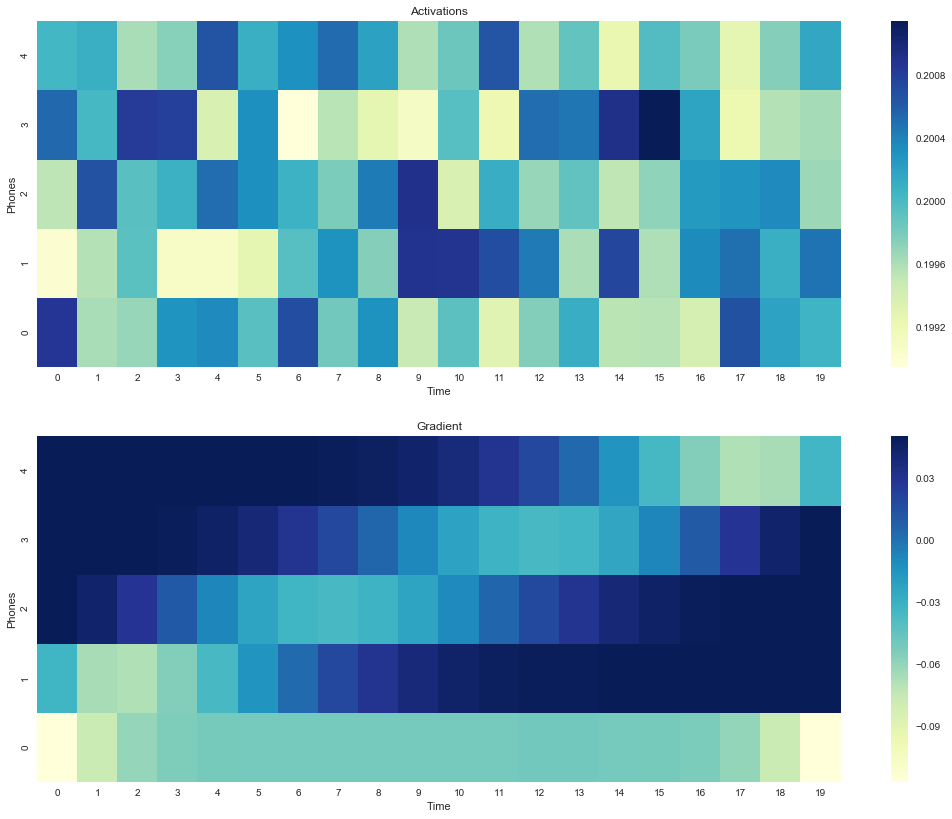

In [3]:
d = get_flattish()
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

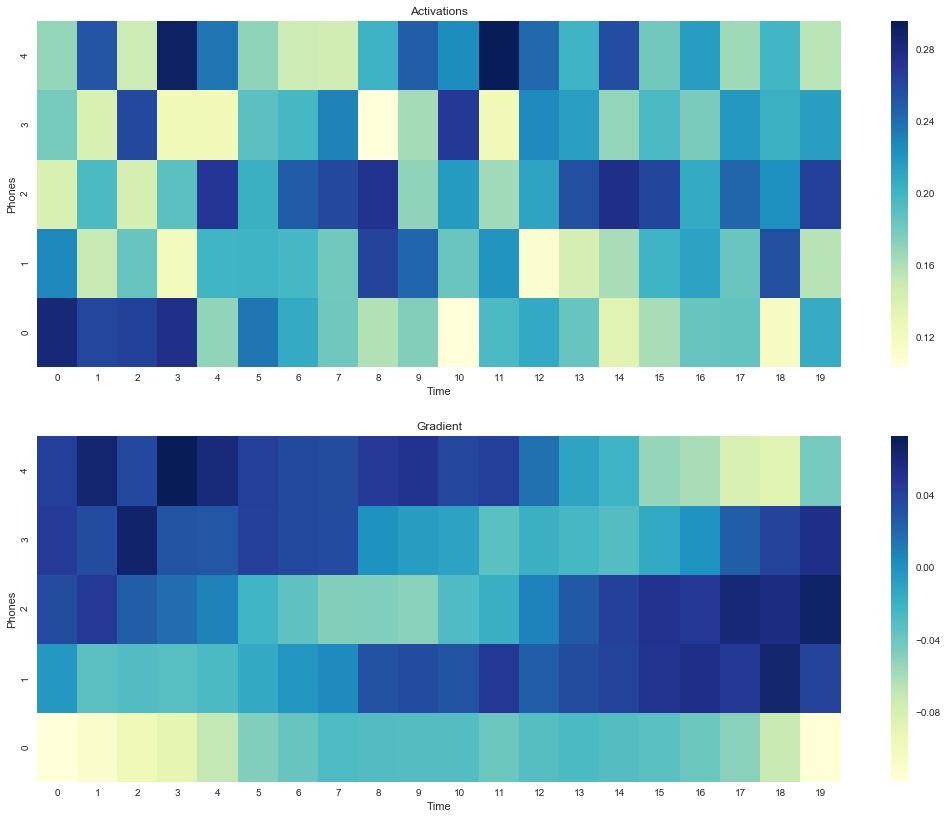

In [4]:
d = get_rand()
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

## Sensitivity to Starting Conditions

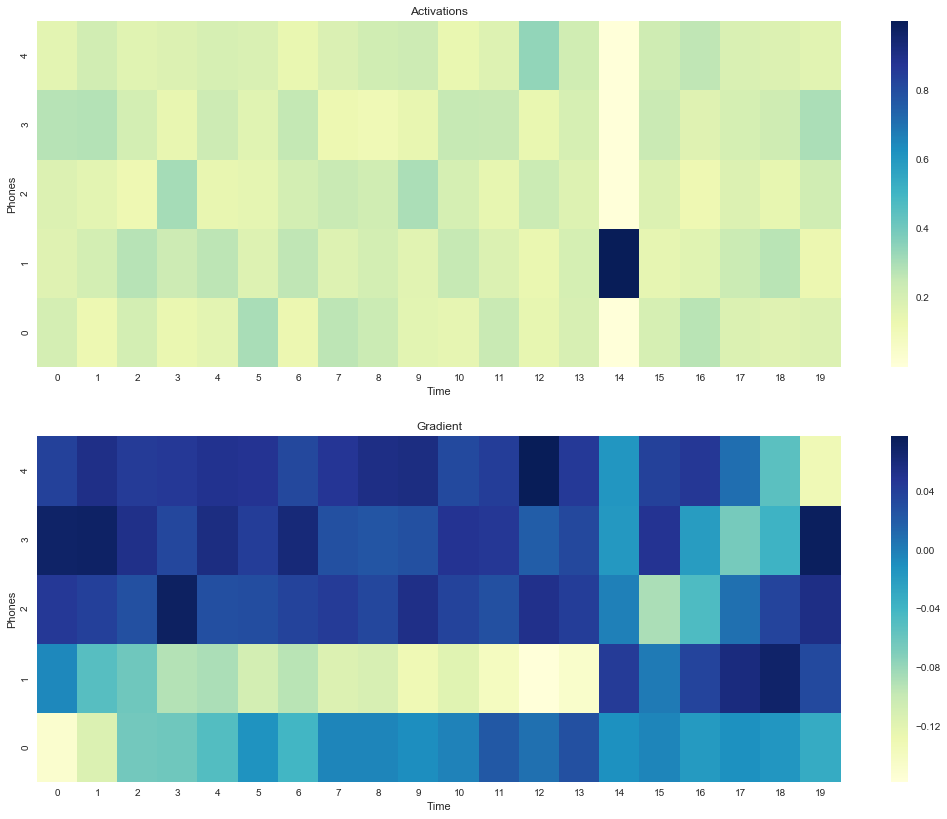

In [5]:

d = get_bump(big_activ=(1, 14), bump=10 )
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

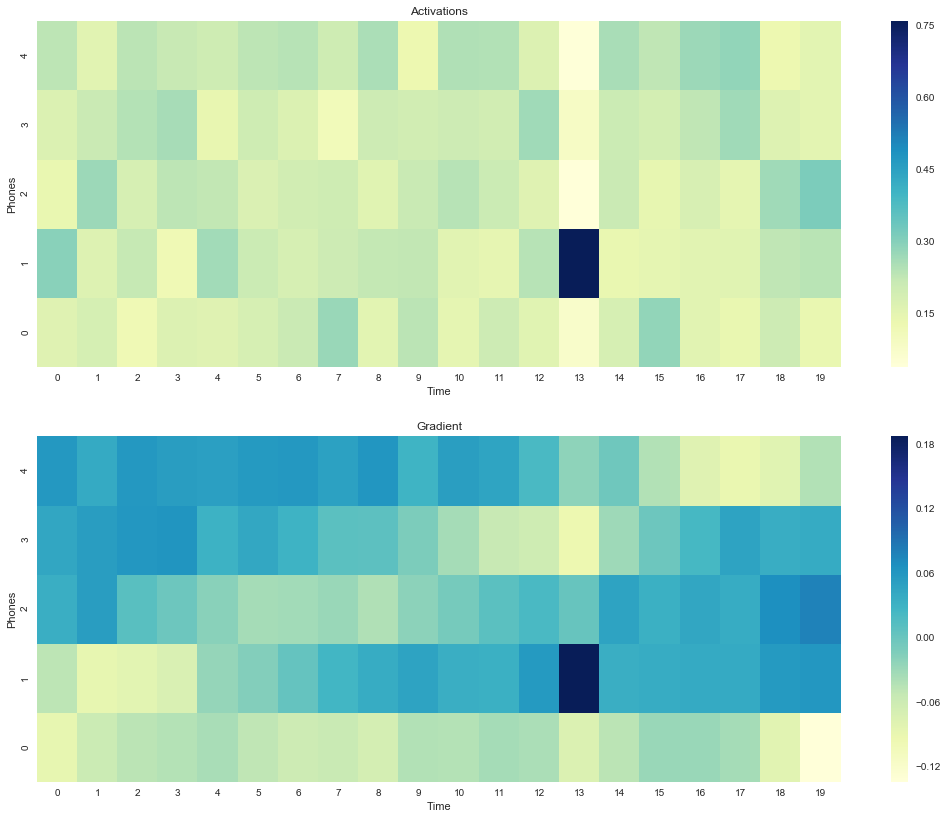

In [6]:
# but  not always
d = get_bump(big_activ=(1, 13), bump=3)
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

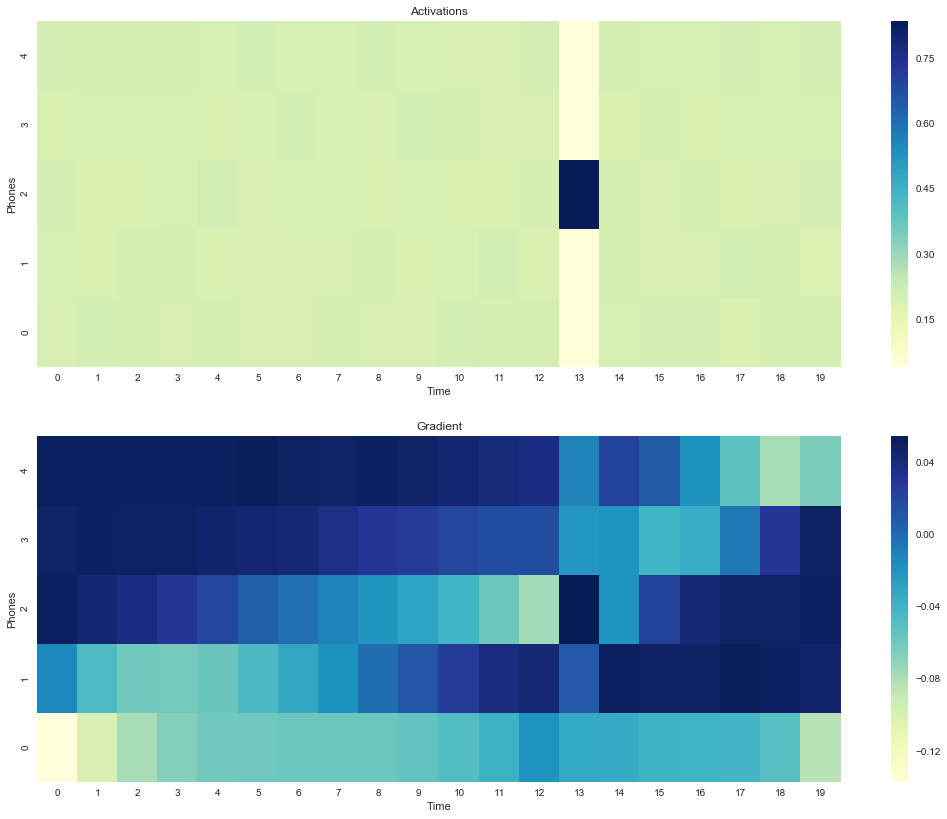

In [7]:
# position matters!
d = get_bump(big_activ=(2, 13), bump=3, flat=True )
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

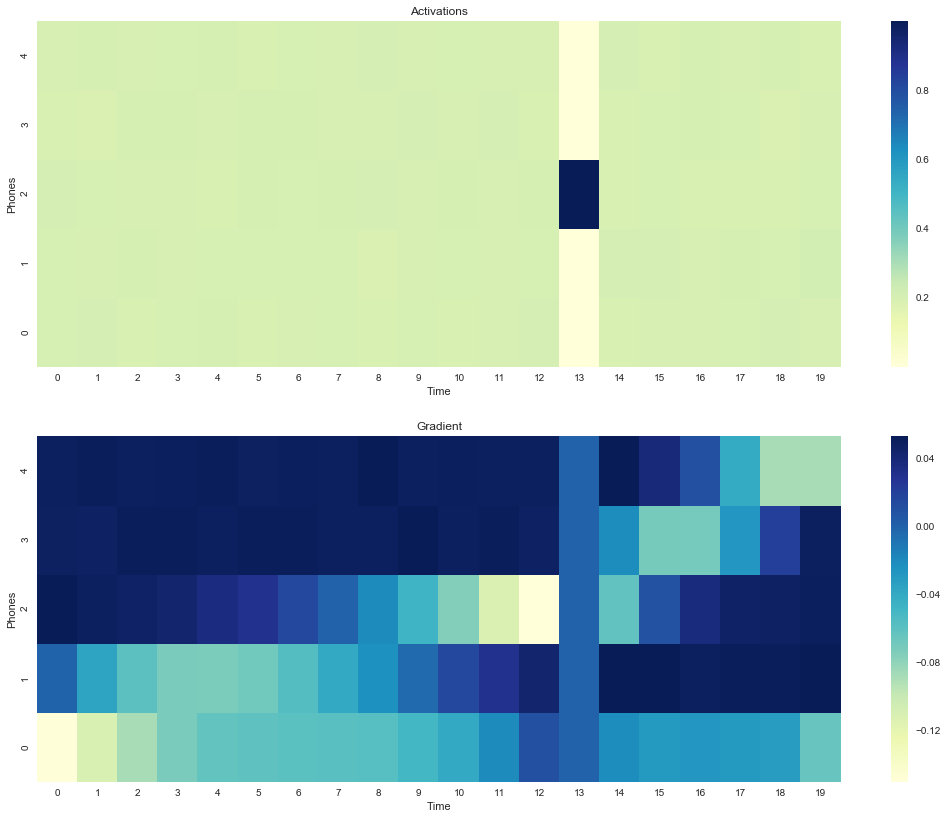

In [8]:
# makes paths slightly tighter though
d = get_bump(big_activ=(2, 13), bump=10, flat=True )
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

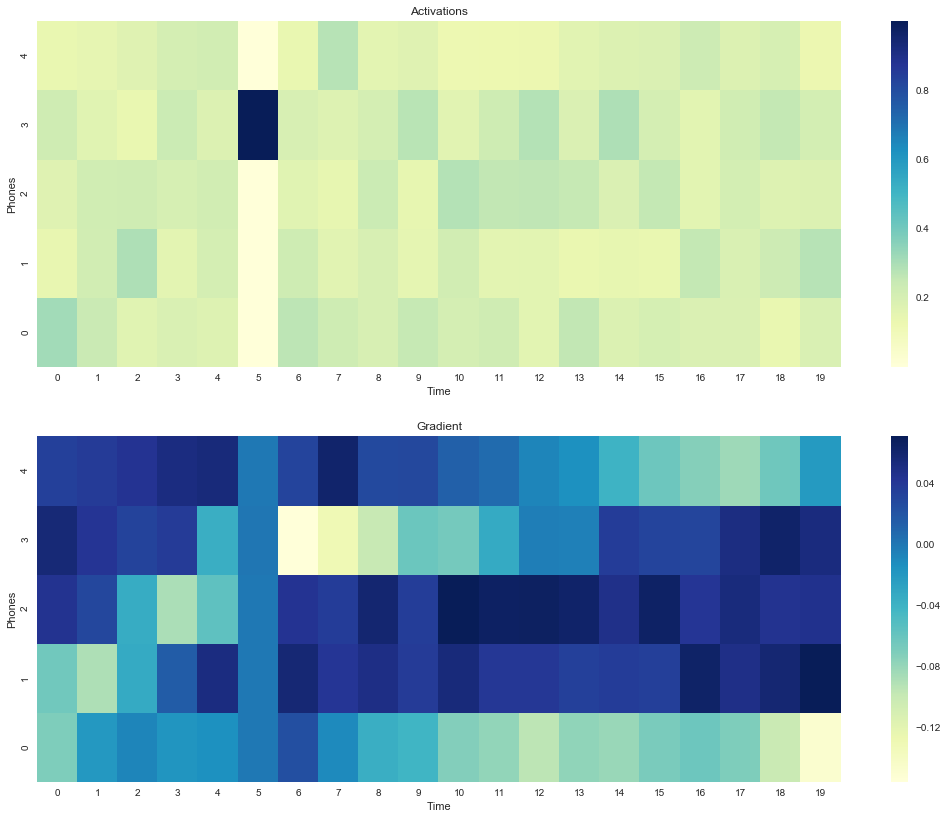

In [9]:
# works both ways!
d = get_bump(big_activ=(3, 5), bump=10 )
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

## Poor performance on long sounds

In [108]:
d_small = get_flattish((4, 5))
d_big = get_flattish((250, 20))

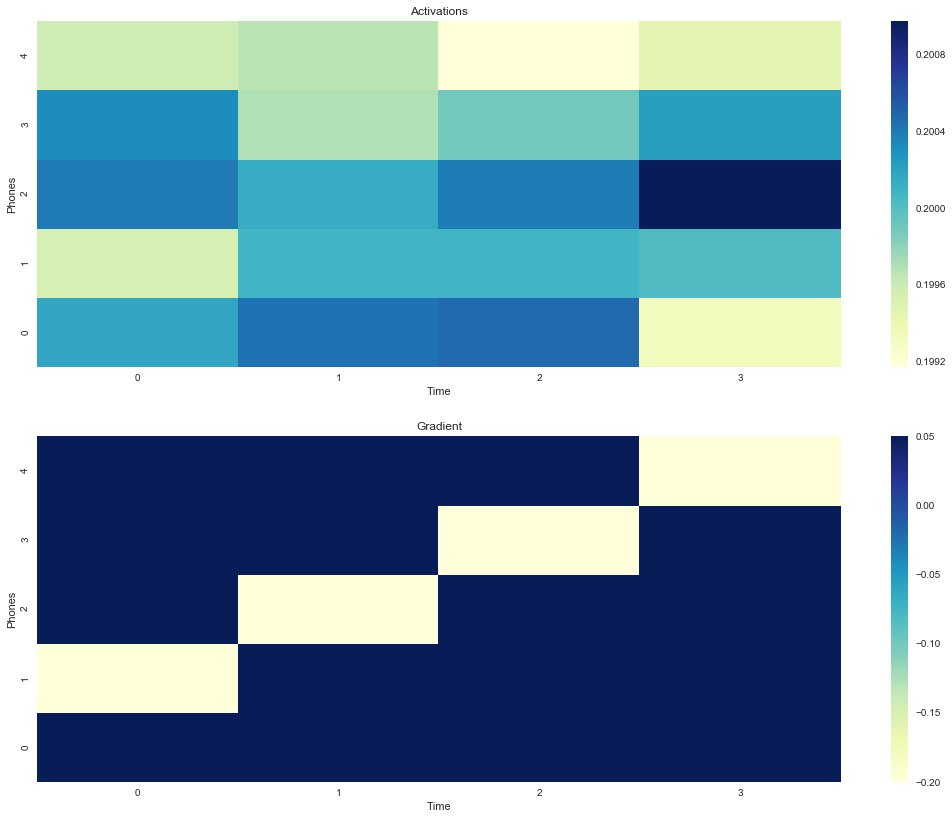

In [11]:
double_posterior(*get_simple_ctc_grads(d_small))

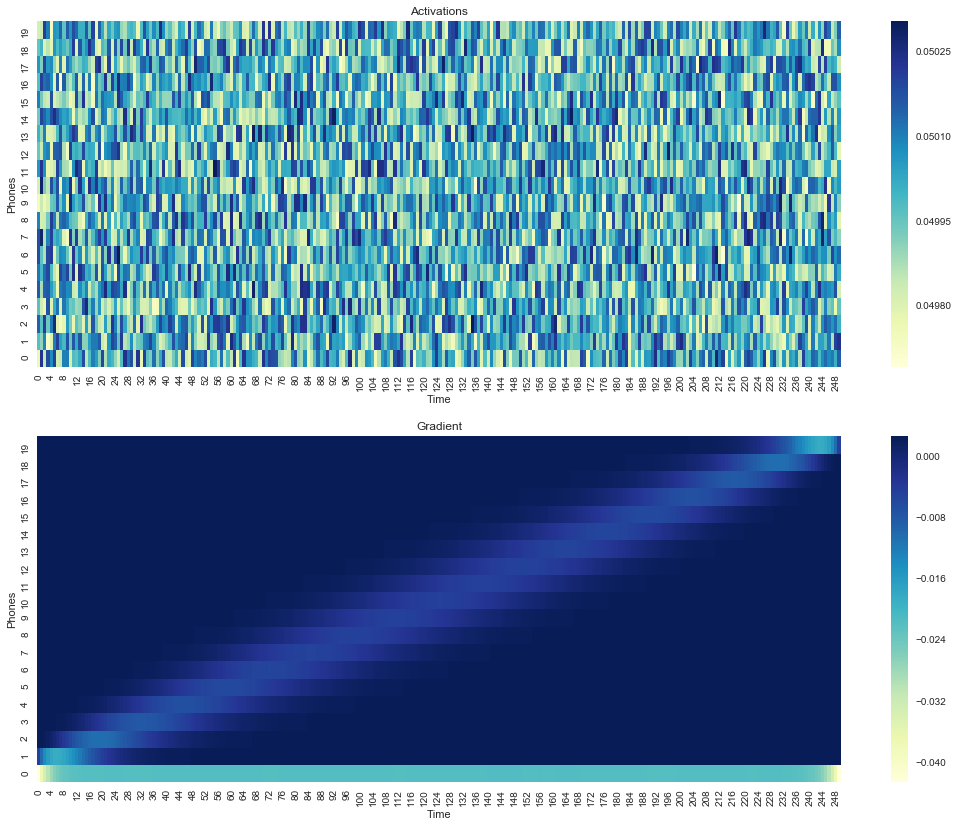

In [12]:
double_posterior(*get_simple_ctc_grads(d_big))

Firstly, we can learn faster from short labels than from longer labels. This should be fairly obvious - consider the combinatoric argument here, in that phone probabilities can only advance or stay the same for each time step. For C states and T timesteps, we have to advance C times and stay the same for T-C times. This gives an ordering of `T!/[C! * (T-C)!].` or Choose(T,C) possible paths. For our above examples

    1. 20 T and 5 States = 1554 paths
    2. 250T and 20 States =  1.7126914e+29 paths

Secondly, given the realisation that we have heavy dependence on initial state, a model that is able to identify certain sounds will be able to learn a lot more than a network that has no idea what it's doing. In this case, the dependence on initial state is an advantage - it is framed as a network that has already learnt some parts of the task, and is now using it's existing knowledge to be more precise.


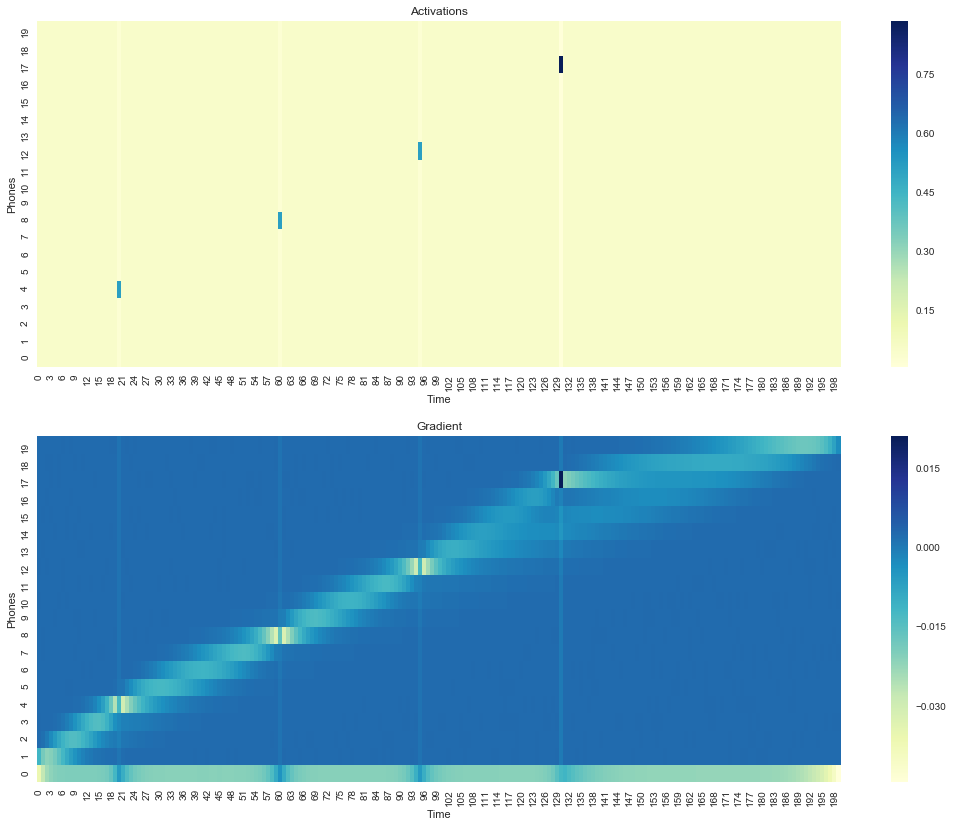

In [13]:
d_big = get_flattish((200, 20))
d_big[20][0][4] += 3
d_big[60][0][8] += 3
d_big[95][0][12] += 3
d_big[130][0][17] += 5
double_posterior(*get_simple_ctc_grads(d_big))

As we can see the gradients here are significantly bigger and we're actually able to effectively reduce the search space and make use of the information.

## Curriculum Learning
This motivates an approach called "curriculum learning" -> we start networks on short sounds and words and graduate to longer words and then finally phrases in a multi-stage training.

For wakeword training, we only want to identify the correct phones. One way of adding more data to our network would be to use a phonetic dictionary we can use to get more words which only contain the necessary phones

In [14]:
GOOG = set("ow k ey g uw g l".split())
ALEXA = set("aa l ih k s aa".split())
DB = set("l ih s n d oh l b iy".split())  # "Listen Dolby"

In [15]:
def get_wordlist(phones):
    with open("beep-1.0") as f:
        for line in f:
            word, *wph = line.split()
            if word.isalpha() and len(wph)>1:
                if not (set(wph) - phones):
                    # i.e. no extra phones
                    yield word.lower(), wph

In [16]:
dbl = sorted(get_wordlist(DB), key=lambda k: len(k[1]))
amaz = sorted(get_wordlist(ALEXA), key=lambda k: len(k[1]))
alphabet = sorted(get_wordlist(GOOG), key=lambda k: len(k[1]))

In [17]:
import random

In [18]:
print(len(dbl))
random.sample(dbl, 10)

288


[('knob', ['n', 'oh', 'b']),
 ('nibbled', ['n', 'ih', 'b', 'l', 'd']),
 ('cillin', ['s', 'ih', 'l', 'ih', 'n']),
 ('od', ['oh', 'd']),
 ('sissy', ['s', 'ih', 's', 'iy']),
 ('eel', ['iy', 'l']),
 ('dolly', ['d', 'oh', 'l', 'iy']),
 ('bodice', ['b', 'oh', 'd', 'ih', 's']),
 ('lean', ['l', 'iy', 'n']),
 ('kneaded', ['n', 'iy', 'd', 'ih', 'd'])]

In [19]:
print(len(amaz))
random.sample(amaz, 10)

63


[('chiliss', ['k', 'ih', 'l', 'ih', 's']),
 ('click', ['k', 'l', 'ih', 'k']),
 ('carsick', ['k', 'aa', 's', 'ih', 'k']),
 ('lick', ['l', 'ih', 'k']),
 ('sicks', ['s', 'ih', 'k', 's']),
 ('castle', ['k', 'aa', 's', 'l']),
 ('ilk', ['ih', 'l', 'k']),
 ('cill', ['s', 'ih', 'l']),
 ('chilis', ['k', 'ih', 'l', 'ih', 's']),
 ('casks', ['k', 'aa', 's', 'k', 's'])]

In [20]:
print(len(alphabet))
random.sample(alphabet, 10)

51


[('coke', ['k', 'ow', 'k']),
 ('low', ['l', 'ow']),
 ('loco', ['l', 'ow', 'k', 'ow']),
 ('ogle', ['ow', 'g', 'l']),
 ('cooley', ['k', 'uw', 'l', 'ey']),
 ('gooley', ['g', 'uw', 'l', 'ey']),
 ('coups', ['k', 'uw']),
 ('kail', ['k', 'ey', 'l']),
 ('lieu', ['l', 'uw']),
 ('kayley', ['k', 'ey', 'l', 'ey'])]

## CTC in Deep Learning



In [49]:
def train_ctc(data, target=None, numepochs=10):
    T, N, C = data.shape
    data = data.requires_grad_(True)
    ctcloss = nn.CTCLoss()
    if not target: 
        target = torch.arange(1, C)
    inlen = torch.IntTensor([T])
    target_len = torch.IntTensor([len(target)])
    
#     print(T, N, C)
#     print(target, inlen, target_len)

    global hval
    hval = {}
#     data.register_hook(dhook)
    
    for epoch in range(numepochs):
        data.register_hook(dhook)
        loss = ctcloss(data.log_softmax(2), target, inlen, target_len)
        loss.backward()
        # bootleg SGD
        data = data - .5 * hval["dgrad"]
    
    endp = data.softmax(2).squeeze(1).T.detach().numpy()
    grad = hval["dgrad"].squeeze(1).T.detach().numpy()
    return endp, grad


In [70]:
d = get_flattish()
d2 = d.clone()  # train will mutate data
epochs = 200
epnd, g = train_ctc(d2, numepochs=epochs)

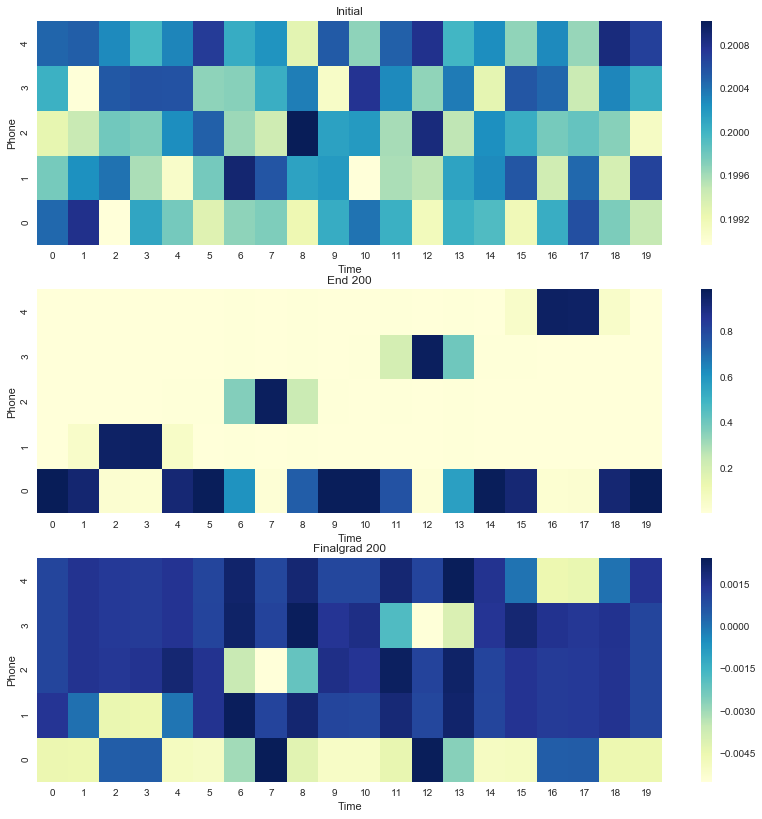

In [71]:
dnumpy = d.squeeze(1).softmax(-1).T.detach().numpy()
plt.figure(figsize=(14,14))
plt.subplot(311)
posteriorgram(dnumpy, "Time", 'Phone', "Initial")
plt.subplot(312)
posteriorgram(epnd, "Time", 'Phone', f"End {epochs}")
plt.subplot(313)
posteriorgram(g, "Time", 'Phone', f"Finalgrad {epochs}")

In [66]:
d = get_bump()
d2 = d.clone()  # train will mutate data
epochs = 100
epnd_shift, g_shift = train_ctc(d2, numepochs=epochs)

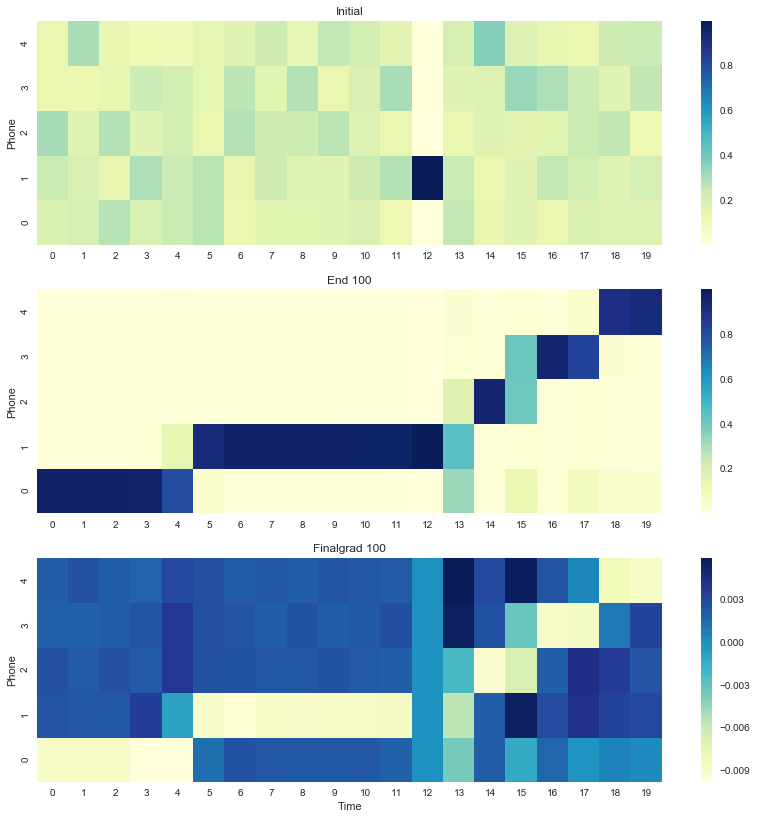

In [67]:
dnumpy = d.squeeze(1).softmax(-1).T.detach().numpy()
plt.figure(figsize=(14,14))
plt.subplot(311)
posteriorgram(dnumpy, "", 'Phone', "Initial")
plt.subplot(312)
posteriorgram(epnd_shift, "", 'Phone', f"End {epochs}")
plt.subplot(313)
posteriorgram(g_shift, "Time", 'Phone', f"Finalgrad {epochs}")

In [74]:
d = get_bump(bump=3)
d2 = d.clone()  # train will mutate data
epochs = 100
epnd_b, g_b = train_ctc(d2, numepochs=epochs)

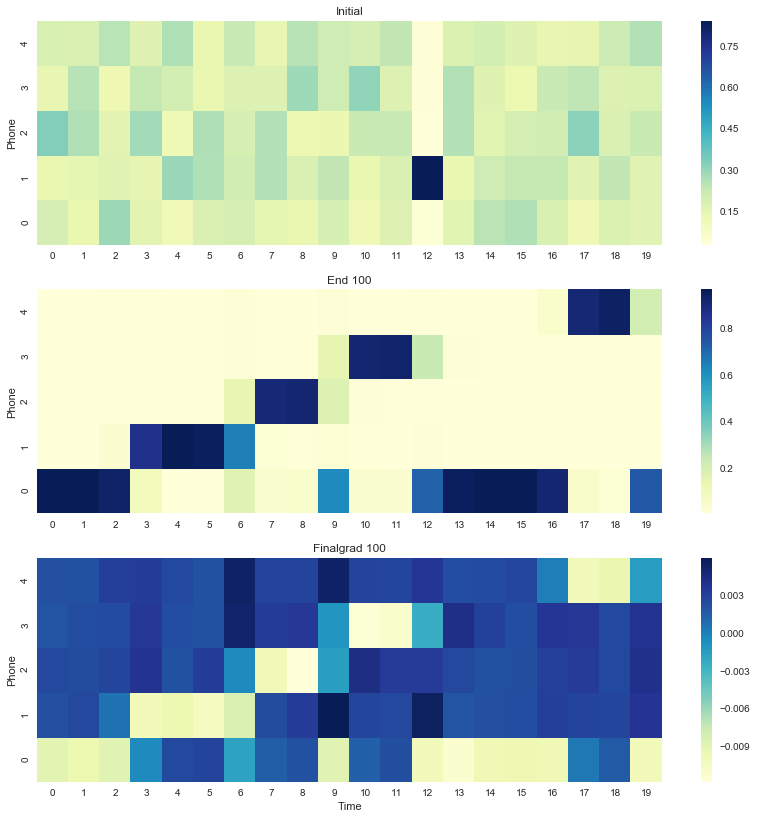

In [69]:
dnumpy = d.squeeze(1).softmax(-1).T.detach().numpy()
plt.figure(figsize=(14,14))
plt.subplot(311)
posteriorgram(dnumpy, "", 'Phone', "Initial")
plt.subplot(312)
posteriorgram(epnd_b, "", 'Phone', f"End {epochs}")
plt.subplot(313)
posteriorgram(g_b, "Time", 'Phone', f"Finalgrad {epochs}")

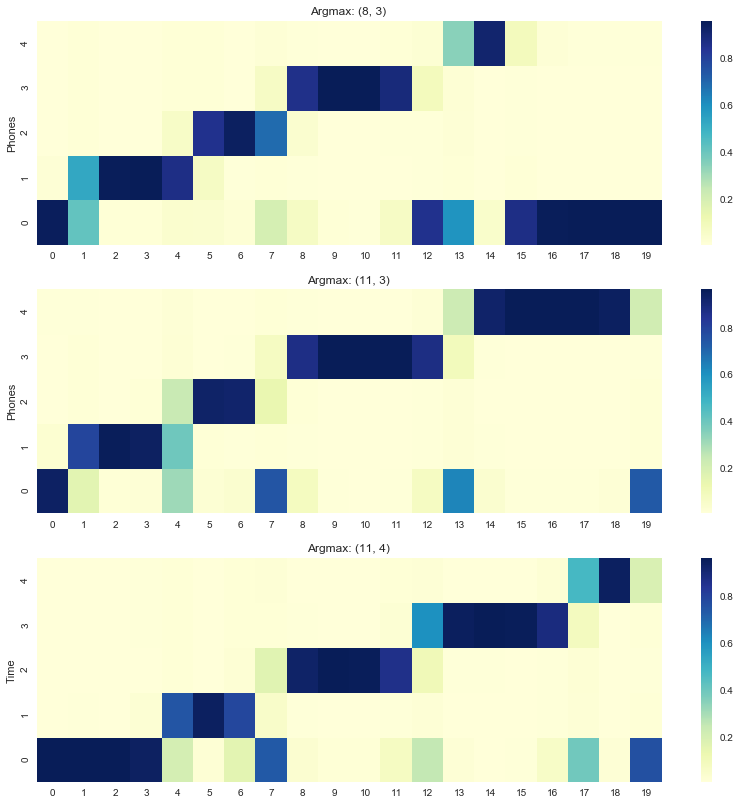

In [107]:
plt.figure(figsize=(14,14))
for i in range(3):
    plt.subplot(311+i)
    d = get_rand()
    maxloc = np.unravel_index(d.log_softmax(2).argmax(), d.shape)[::2]
    end, _ = train_ctc(d, numepochs=100)
    posteriorgram(end, "", "Phones", f"Argmax: {maxloc}")
    
plt.ylabel("Time");
    

Now with artifical bumps included

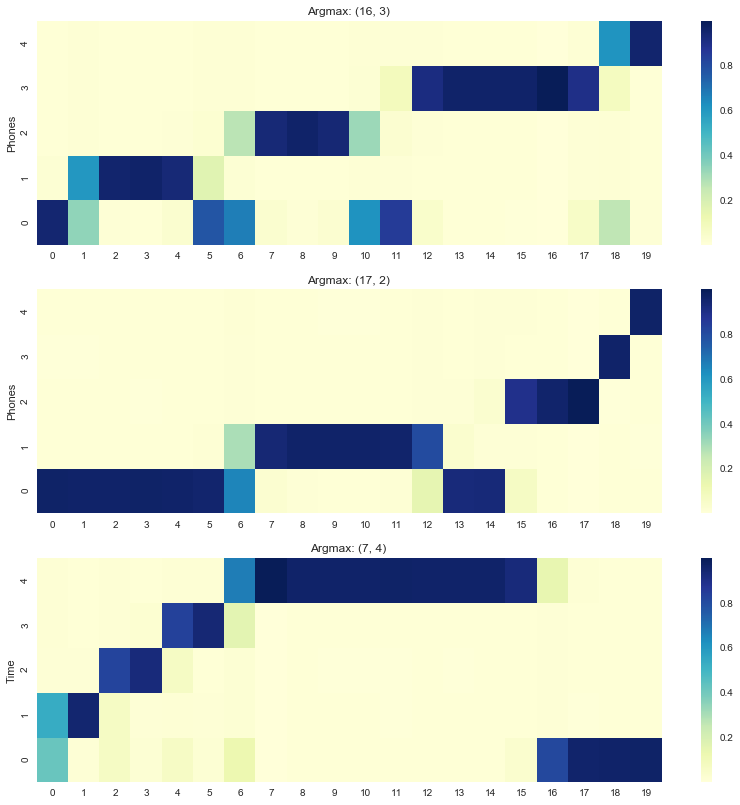

In [105]:
plt.figure(figsize=(14,14))
for i in range(3):
    plt.subplot(311+i)
    T, C = np.random.randint(20), np.random.randint(5)
    d = get_bump(big_activ=(C, T))
    maxloc = np.unravel_index(d.log_softmax(2).argmax(), d.shape)[::2]
    end, _ = train_ctc(d, numepochs=100)
    posteriorgram(end, "", "Phones", f"Argmax: {maxloc} ")
    
plt.ylabel("Time");
    

## CTC and Baum Welch

The Baum Welch procedure is the foundation of CTC, however CTC is more constrained. This includes

1. The blank label - CTC mandates a label as the blank label in which the network doesn't make any predictions. This allows the network to be selective with it's predictions.
2. Constrained transition matrix - the CTC transition matrix is to either to stay in current phone, go blank or go to next voiced phone. (If prediction is blank, it stays blank or to next phone). Phones can be repeated, but you don't have branching paths, nor recursive transitions.

These are not well articulated (in fact Graves does not make any explicit links to Baum Welch) and are poorly justified. We will focus on part 2 since blank label investigations require real data for good intuition.

We refer to "Multi-path CTC" for the equations derived there. They have been verified to work within the pytorch framework of autograd.

In [252]:
def multi_ctc(ctc, data, targets, inlen, target_len):
    """
    For simplicity, we assume that the targets are equal length
    This is not necessary, but makes for slightly simpler code here
    """
    loss = 0
    for target in targets:
        l = ctc(data, target, inlen, target_len)
        print(f"{l} for {target}")
        loss += torch.exp(-l)
    totloss =  -torch.log(loss)
    print(f"combo: {totloss}")
    return totloss

class MultiCTC(nn.Module):
    pass

In [253]:
def train_multi(data, targets, epochs=100):
    T, N, C = data.shape
    data = data.requires_grad_(True)
    ctcloss = nn.CTCLoss()
    inlen = torch.IntTensor([T])
    target_len = torch.IntTensor([len(targets[0])])
    

    global hval
    hval = {}
    
    for epoch in range(epochs):
        data.register_hook(dhook)
        loss = multi_ctc(ctcloss, data.log_softmax(2), targets, inlen, target_len)
        loss.backward()
        # bootleg SGD
        data = data - .5 * hval["dgrad"]
    
    endp = data.softmax(2).squeeze(1).T.detach().numpy()
    grad = hval["dgrad"].squeeze(1).T.detach().numpy()
    return endp, grad
    

1.6094379425048828 for tensor([1, 3, 4], dtype=torch.int32)
1.6094379425048828 for tensor([1, 2, 4], dtype=torch.int32)
combo: 0.916290819644928
1.5056926012039185 for tensor([1, 3, 4], dtype=torch.int32)
1.5056926012039185 for tensor([1, 2, 4], dtype=torch.int32)
combo: 0.8125454187393188
1.4091777801513672 for tensor([1, 3, 4], dtype=torch.int32)
1.4091777801513672 for tensor([1, 2, 4], dtype=torch.int32)
combo: 0.7160305976867676
1.3199034929275513 for tensor([1, 3, 4], dtype=torch.int32)
1.3199034929275513 for tensor([1, 2, 4], dtype=torch.int32)
combo: 0.6267563700675964
1.2377606630325317 for tensor([1, 3, 4], dtype=torch.int32)
1.2377606630325317 for tensor([1, 2, 4], dtype=torch.int32)
combo: 0.5446134209632874
1.1625310182571411 for tensor([1, 3, 4], dtype=torch.int32)
1.1625310182571411 for tensor([1, 2, 4], dtype=torch.int32)
combo: 0.4693838357925415
1.093902587890625 for tensor([1, 3, 4], dtype=torch.int32)
1.093902587890625 for tensor([1, 2, 4], dtype=torch.int32)
combo: 

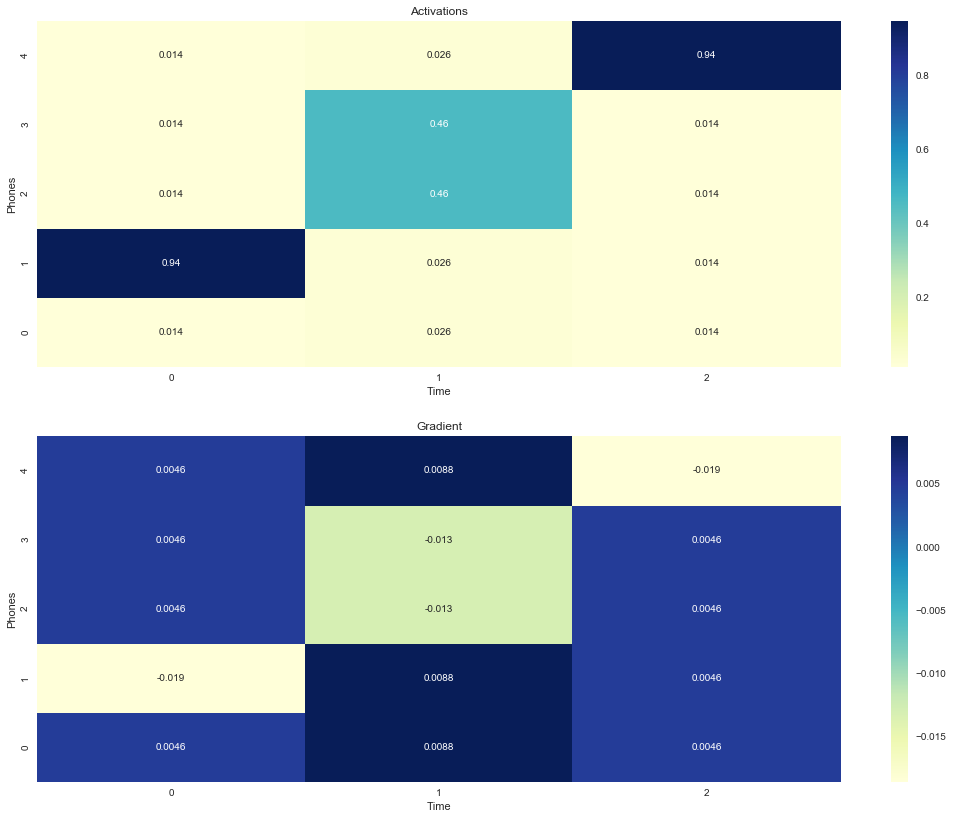

In [254]:
data = torch.zeros(3, 1, 5)
targets = [torch.IntTensor([1,3, 4]) , torch.IntTensor([1,2,4])]

end, g = train_multi(data, targets, 100)
double_posterior(end, g, annot=True)

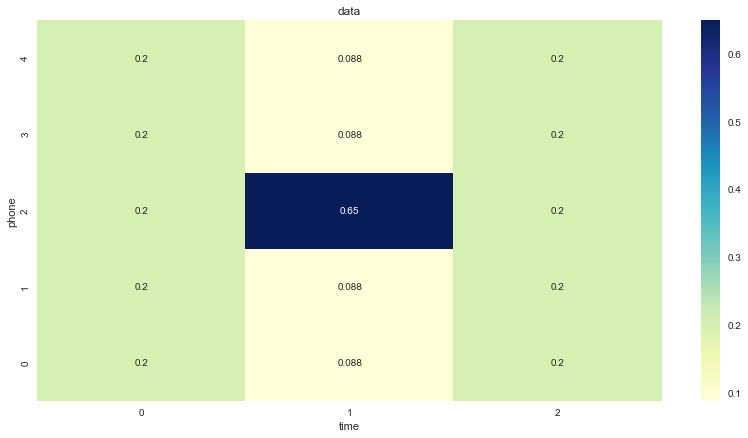

In [247]:
data_b = torch.zeros(3, 1, 5)
data_b[1,0,2] += 2
targets = [torch.IntTensor([1,2, 4]), torch.IntTensor([1,3,4])]
plt.figure(figsize=(14,7))
posteriorgram(to_plot(data_b.softmax(2)), "time", "phone", "data", annot=True)

1.2171763181686401 for tensor([1, 2, 4], dtype=torch.int32)
1.883842945098877 for tensor([1, 3, 4], dtype=torch.int32)


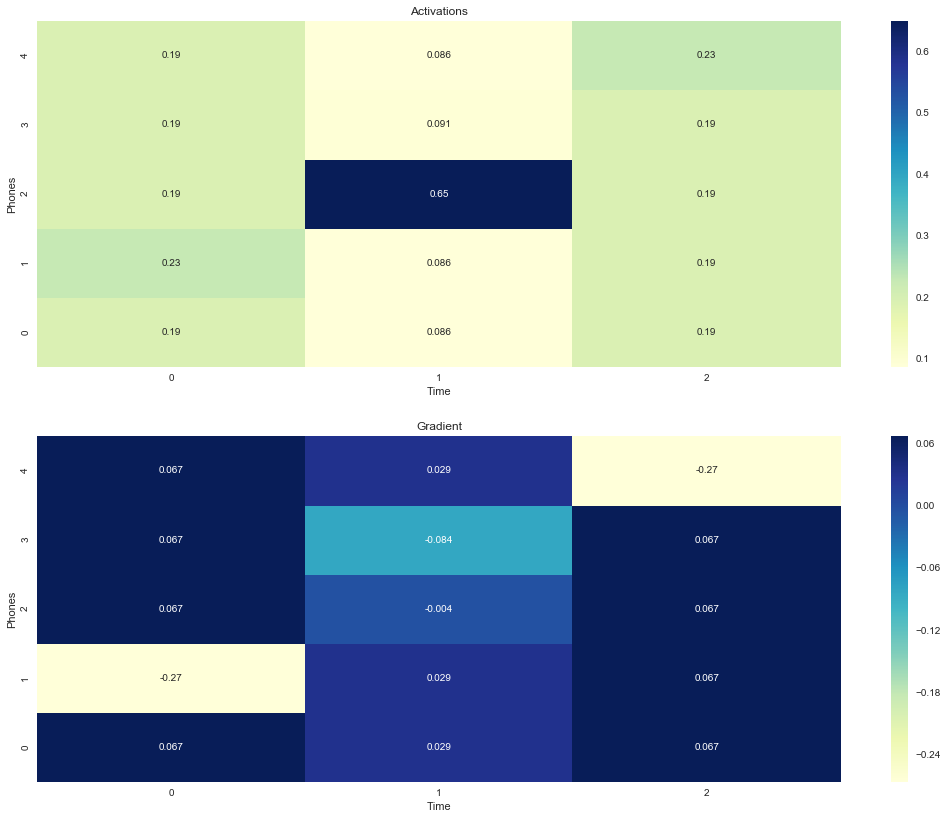

In [248]:
end, g = train_multi(data_b, targets, 1)
double_posterior(end, g, annot=True)

1.2171763181686401 for tensor([1, 2, 4], dtype=torch.int32)
1.883842945098877 for tensor([1, 3, 4], dtype=torch.int32)


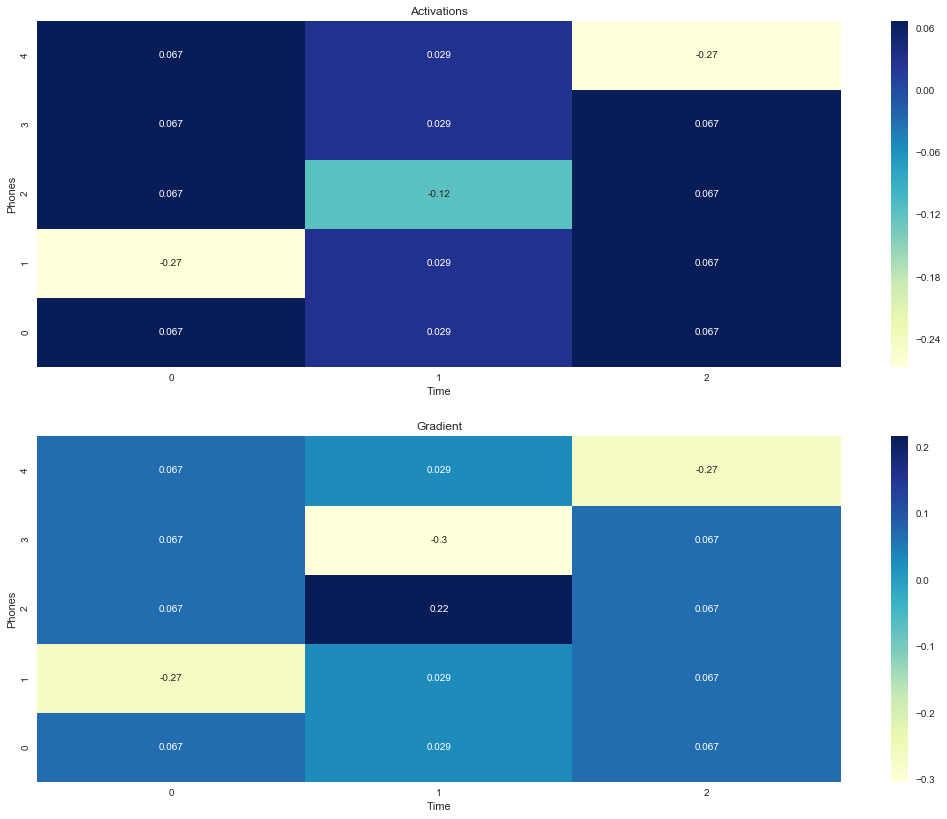

In [249]:
end, g_0 = train_multi(data_b, targets[0::2], 1)
end, g_1 = train_multi(data_b, targets[1::2], 1)

double_posterior(g_0, g_1, annot=True)

In [251]:
data_b = torch.zeros(3, 1, 5)
data_b[1,0,2] += 2
ds = data_b.log_softmax(2).squeeze(1)
p1 = ds[0,1] + ds[1,2] + ds[2,4]
print(p1)
print(np.log(-p1))
v1 = p1.exp().item()
v1

tensor(-3.6515)
tensor(1.2951)


0.02595142275094986

In [240]:
p2 = ds[0,1] + ds[1,3] + ds[2,4]
print(p2)
v2 = p2.exp().item()
v2

tensor(-13.2191)


1.8156680425818195e-06

In [241]:
m1 = v1/(v1 + v2)

In [242]:
m2 = v2/(v1+v2)

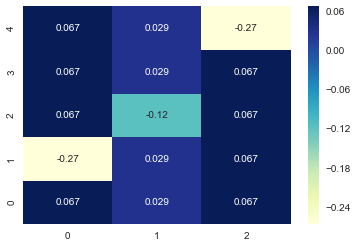

In [243]:
posteriorgram(g_0 * m1 + g_1*m2, "", "", "", annot=True)

In [244]:
np.log(-p1.item())

1.1690886334761688

In [245]:
np.log(-p2.item())

2.5816595068517927

## The Blank Label

How do we train a network without a blank label

In [102]:
from torch import nn
class NoBlank(nn.Module):
    def forward(self, x):
        T, N, C = x.shape
        # ideally we do the log_softmax before passing through this stage.
        newt = torch.full((T, N, 1), -1e10) 
        return torch.cat((newt, x), -1)

    def backward(self, grad_output):
        return grad_output[:, :, 1:]


In [103]:
def get_noblank_grads(data, target=None):
    T, N, C = data.shape
    data = data.requires_grad_(True)
    ctcloss = nn.CTCLoss()
    if not target: 
        target = torch.arange(1, C+1)
    inlen = torch.IntTensor([T])
    target_len = torch.IntTensor([len(target)])
    
#     print(T, N, C)
#     print(target, inlen, target_len)

    global hval
    hval = {}
    data.register_hook(dhook)
    m = NoBlank()
    
    loss = ctcloss(m(data.log_softmax(2)), target, inlen, target_len)
    loss.backward()
    
    initial = data.softmax(2).squeeze(1).T.detach().numpy()
    grad = hval["dgrad"].squeeze(1).T.detach().numpy()
    return initial, grad

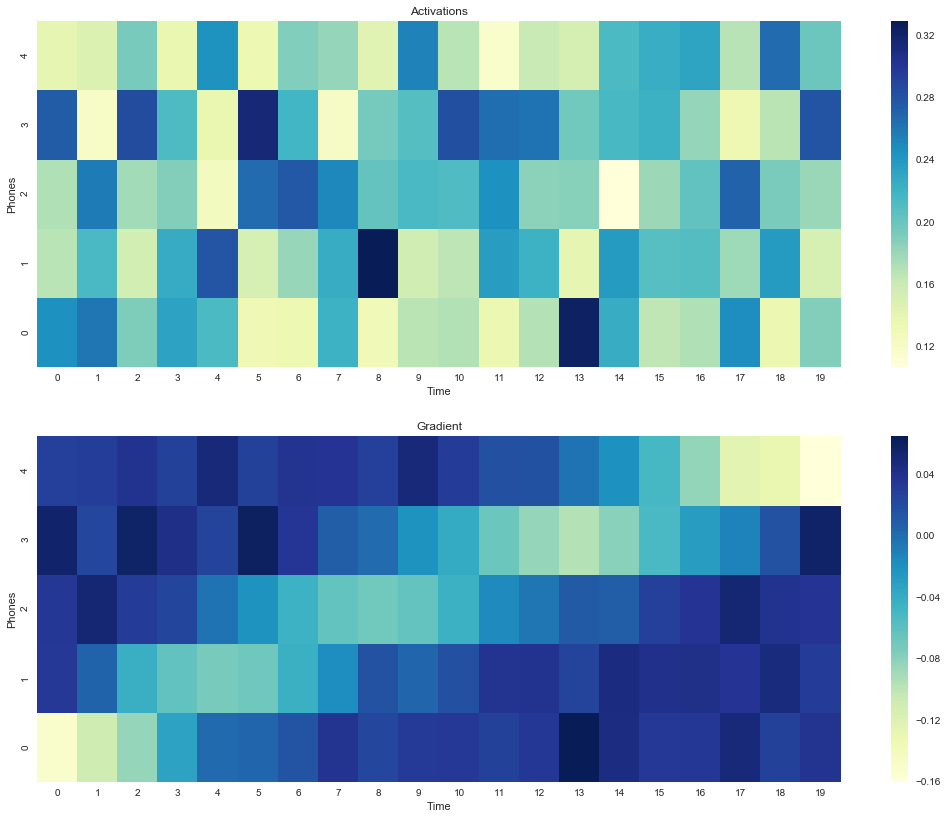

In [104]:
d = get_rand()
double_posterior(*get_noblank_grads(d))

In [93]:
def train_ctc_noblank(data, target=None, numepochs=10):
    T, N, C = data.shape
    data = data.requires_grad_(True)
    ctcloss = nn.CTCLoss()
    if not target: 
        target = torch.arange(1, C+1)
    inlen = torch.IntTensor([T])
    target_len = torch.IntTensor([len(target)])
    
#     print(T, N, C)
#     print(target, inlen, target_len)

    global hval
    hval = {}
    m = NoBlank()
#     data.register_hook(dhook)
    
    for epoch in range(numepochs):
        data.register_hook(dhook)
        loss = ctcloss(m(data).log_softmax(2), target, inlen, target_len)
        loss.backward()
        # bootleg SGD
        data = data - .5 * hval["dgrad"]
    
    endp = data.softmax(2).squeeze(1).T.detach().numpy()
    grad = hval["dgrad"].squeeze(1).T.detach().numpy()
    return endp, grad


In [97]:
d = get_rand()
ep, g = train_ctc_noblank(d, numepochs=100)

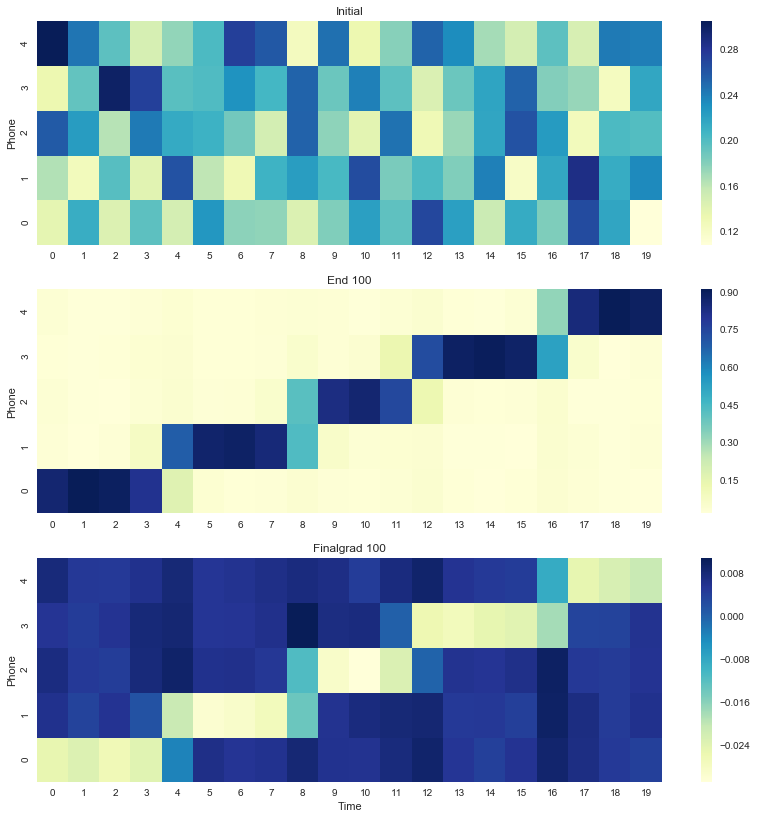

In [98]:
dnumpy = d.squeeze(1).softmax(-1).T.detach().numpy()
plt.figure(figsize=(14,14))
plt.subplot(311)
posteriorgram(dnumpy, "", 'Phone', "Initial")
plt.subplot(312)
posteriorgram(ep, "", 'Phone', f"End {epochs}")
plt.subplot(313)
posteriorgram(g, "Time", 'Phone', f"Finalgrad {epochs}")

From some real results, not having a blank label results in poor performance. This is due to a few reasons - our phone labelling is kind of hand designed. I.e. words like water can be prononuced very differently and secondly, phones sound different in context, the t in tell vs the t in water are quite different. Forcing a labelling to cover very many different sounds that might have overlap results in the performance degrading in a similar argument between VAE vs GANs. The blank label allows us to fit only the most specific sound of that phone instead of trying to fit everything and thus can be more certain.

On training wakewords, this is less of an issue since each sound is heard in one way only and thus there isn't conflicting information from phone labellings to get confused by. 

## I don't like notebooks

See: https://docs.google.com/presentation/d/1n2RlMdmv1p25Xy5thJUhkKGvjtV-dkAIsUXP-AL4ffI/edit#slide=id.g362da58057_0_1 for a more detailed look at why